# Calculate lateralized ERPs

In this notebook we calculate and evaluate the CDA. Further, we run some
control analyses to check whether the selection of our ROI or the time-window
played a crucial role for the observed results.

In [3]:
# import os
import os.path as op
from pathlib import Path
import numpy as np
import scipy
from collections import defaultdict
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
import pandas as pd
import seaborn as sns
import mne

from scipy import stats
from mne.stats import permutation_cluster_1samp_test

from library import helpers, config


In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def ci(vec, confidence=0.95):
    """Calculate the confidence interval of a vector.
    
    Parameters
    ----------
    vec : array-like
        Vector to calculate the confidence interval for.
    
    confidence : float (default: 0.95)
        Confidence level (1 - alpha) as a float between 0 and 1.
    
    Returns
    -------
    interval : tuple
        Confidence interval as a tuple of floats.
    """
    return scipy.stats.t.interval(
        confidence=confidence,
        df=len(vec) - 1,
        loc=np.mean(vec),
        scale=np.std(vec, ddof=1) / np.sqrt(len(vec)),
    )


def get_cmci(
    normalized_vals: np.array, n_factorlevels: int, alpha: float = 0.05
) -> tuple:
    """Calculate Cosineau-Morey CIs

    Parameters
    ----------
    normalized_vals : numpy.array
        Vector of samples of 1 experimental condition.
    n_factorlevels : int
        Number of factor levels across all within-factors.
    alpha : float, optional
        Alpha level, by default 0.05:float

    Returns
    -------
    tuple
        Boundaries of the CI
    """

    mean = np.mean(normalized_vals)

    morey_factor = np.sqrt(n_factorlevels / (n_factorlevels - 1))
    tval = scipy.stats.t.ppf(1 - (alpha / 2), len(normalized_vals) - 1)

    sem = np.std(normalized_vals, ddof=1) / np.sqrt(len(normalized_vals))

    ci = tval * morey_factor * sem

    lower = mean - ci
    upper = mean + ci

    return (lower, upper)


def get_evokeds_dict(sub_list, epo_part, plt_dict, data_type="difference"):
    """Get a dictionary of evoked responses.
    
    Parameters
    ----------
    sub_list : list of int
        List of subject IDs.
    
    epo_part : str
        Epoch part (e.g. "stimon" or "fulllength").
    
    plt_dict : dict
        Dictionary with plotting parameters.
    
    data_type : str (default: "difference")
        Data type. Either "difference" or "collapsed".
    
    Returns
    -------
    evokeds : defaultdict(list)
        Dictionary of evoked responses.
    """

    evokeds = defaultdict(list)
    for sub in sub_list:
        if data_type not in ["difference", "collapsed"]:
            raise ValueError(
                f"Invalid data type '{data_type}'. Has to be either 'difference' or 'collapsed'."
            )
        subID = "VME_S%02d" % sub
        fname = op.join(
            config.paths["03_preproc-pooled"],
            epo_part,
            data_type,
            f"{subID}-{epo_part}-{data_type}-epo.fif",
        )
        epos = mne.read_epochs(fname, verbose=False)
        if plt_dict["picks"] != None:
            epos.pick_channels(plt_dict["picks"])
        epos.crop(plt_dict[epo_part]["xmin"], plt_dict[epo_part]["xmax"])
        event_dict = helpers.get_event_dict(epos.event_id)
        for load in ["LoadLow", "LoadHigh"]:
            evoked_load = epos[event_dict[load]].copy().average()
            evokeds[load].append(evoked_load)
            for ecc in ["EccS", "EccM", "EccL"]:
                if load == "LoadLow":  # we don't want to do this twice
                    evoked_ecc = epos[event_dict[ecc]].copy().average()
                    evokeds[ecc].append(evoked_ecc)
                # Interaction:
                evoked_interac = epos[event_dict[load]][event_dict[ecc]].copy()
                evoked_interac = evoked_interac.average()
                evokeds[load + ecc].append(evoked_interac)
        evokeds["all"].append(epos.copy().average())
    return evokeds


def plot_main_cda(ax, evokeds):
    """Plot the CDA across all exp conditions.
    
    Parameters
    ----------
    ax : instance of matplotlib Axes
        Axes to plot on.
    
    evokeds : dict
        Dictionary of evoked responses.
    
    Returns
    -------
    None
    """

    label_dict = dict()
    label_dict["CDA: Contra - Ipsi"] = evokeds["all"]

    mne.viz.plot_compare_evokeds(
        label_dict,
        combine="mean",
        # colors = {k: config.colors[k] for k in plt_dict.keys()},
        vlines=[0, 0.2, 2.2],
        ci=0.68,
        ylim=dict(eeg=[-1.5, 1.5]),
        title=None,
        axes=ax,
        show=False,
        truncate_yaxis=False,
        truncate_xaxis=False,
    )

    ax.legend(loc=1, prop={"size": 9})
    ax.axvspan(0, 0.2, color="grey", alpha=0.3)
    ax.axvspan(2.2, 2.3, color="grey", alpha=0.3)
    # ax.set_aspect(0.25)
    ax.set_title("")
    ax.xaxis.label.set_size(9)
    ax.yaxis.label.set_size(9)
    plt.xticks(fontsize=9)


def run_cbp_test(
    data, n_perm=1000, p_initial=0.05, p_thresh=0.05, tail=0.0, adjacency=None
):
    """Run a cluster-based permutation test: paired t-test.

    Parameters
    ----------
    data : ndarray, shape (n_observations, times)
        2d array with difference between conditions (n_observations x timepoints)
    n_perm : int
        Number of permutations, default: 1000
    p_initial : int
        Initial threshold (1st round of cbp test), default: 0.05
    p_thresh : int
        Familywise p value (2nd round of cbp test), default: 0.05
    tail : int
        0: two-sided test (default); -1: left-sided; 1: right-sided
    adjacency : ndarray, shape (n_sensors, n_sensors)
        Adjacency matrix for clustering.

    Returns
    -------
    T_obs : array, shape (n_tests,)
        T-statistic observed for all variables.
    clusters : list
        list of tuple of ndarray, where each ndarray contains the indices of
        locations that together form the given cluster along the given dimension.
    cluster_p_values : array
        P-value for each cluster.

    Notes
    -------
    For details check documentation of `mne.stats.permutation_cluster_1samp_test`.
    """
    
    # number of permutations to run
    n_permutations = n_perm
    # set initial threshold
    p_initial = p_initial
    # set family-wise p-value
    p_thresh = p_thresh
    adjacency = adjacency

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = permutation_cluster_1samp_test(
        data,
        threshold=threshold,
        n_jobs=config.n_jobs,
        verbose=True,
        tail=tail,
        step_down_p=0.05,
        adjacency=adjacency,
        n_permutations=n_permutations,
        seed=42,
    )

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return (T_obs, clusters, cluster_p_values)


def plot_cbp_result_cda(
    ax, T_obs, clusters, cluster_p_values, p_thresh, times_cbp, times_full
):
    """Plot the results of the CBP test by plotting the T values over time,
    highlighting significant clusters.

    Paramteters
    -------
    ax : Axes instance
        Axes object to plot into.
    clusters : list
        Output of `run_cbp_test`.
        List of tuple of ndarray, where each ndarray contains the indices of
        locations that together form the given cluster along the given dimension.
    cluster_p_values : array
        Output of `run_cbp_test`.
        P-value for each cluster.
    p_thresh : int
        Familywise p value (2nd round of cbp test) used in the underlying CBP test
    times_cbp : array, shape (srate * duration retention interval,)
        Sample times.
    times_full : array, shape (srate * duration full trial,)
        Sample times.
    """
    y_max = np.max(np.abs(T_obs)) * np.array([-1.1, 1.1])
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] < p_thresh:
            h1 = ax.axvspan(times_cbp[c[0]], times_cbp[c[-1]], color="r", alpha=0.3)
    ax.plot(times_cbp, T_obs, "g")
    ax.hlines(0, times_full[0], times_full[-1])
    ax.legend(
        (h1,), ("p < %s" % p_thresh,), loc="upper right", ncol=1, prop={"size": 9}
    )
    ax.set(
        xlabel="Time (s)",
        ylabel="T-values",
        ylim=y_max,
        xlim=times_full[np.array([0, -1])],
    )
    plt.tight_layout(pad=0.0)
    ax.axvspan(0, 0.2, color="grey", alpha=0.3)
    ax.axvspan(2.2, 2.3, color="grey", alpha=0.3)
    ax.vlines(
        [0, 0.2, 2.2], *y_max, linestyles="--", colors="k", linewidth=1.0, zorder=1
    )
    # ax.set_aspect(0.33)
    ax.set_title("")
    # ax.set_aspect('auto', adjustable='datalim')
    # ax.set(aspect=1.0/ax.get_data_ratio()*0.25, adjustable='box')
    ax.xaxis.label.set_size(9)
    ax.yaxis.label.set_size(9)


def plot_main_effect(
    evokeds, conds, picks, ax, sign_cluster=None, ci_func=95, show_legend=False
):
    """Plot the main effect of Memory Load on the lateralized ERP.

    Paramteters
    -------
    evokeds : dict
        Dictionnary with Evokeds objects. Can be loaded from disc by using `get_evokeds_dict`.
    ax : Axes instance
        Axes object to plot into.
    sign_cluster : tuple
        Tuple with start and end time of the sign. cluster. If provided, the plot gets overlaid
        with a red box to indicate the time of the cluster. If `None` (default), no box is plotted.

    """

    res = plot_compare(evokeds, conds, ax, ci_func, show_legend)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_ylim((-1.5, 1.5))
    ax.set_xlim((-0.2, 2.3))

    ax.axhline(0, color="k", linewidth=1.0, zorder=-2)
    ax.axvspan(0, 0.2, color="grey", alpha=0.3)
    ax.axvspan(2.2, 2.3, color="grey", alpha=0.3)
    for x in [0, 0.2, 2.2]:
        ax.axvline(x, linestyle="--", color="k", linewidth=1.0, zorder=-2)

    if sign_cluster is not None:
        ax.axvspan(sign_cluster[0], sign_cluster[-1], color="red", alpha=0.1)

    if show_legend:
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(
            loc=1,
            prop={"size": config.plt_label_size},
            title="",
            ncol=3,
            bbox_to_anchor=(1.0, 1.25),
            handles=handles,
            labels=[config.labels[c] for c in conds],
        )

    ax.set_title("")
    ax.xaxis.label.set_size(config.plt_label_size)
    ax.yaxis.label.set_size(config.plt_label_size)
    ax.set_ylabel("CDA amplitude (" + chr(956) + "V)", fontname=config.plt_fontname)
    ax.set_xlabel("Time (s)")

    for tick in ax.get_xticklabels():
        tick.set_fontname(fontname=config.plt_fontname)
        tick.set_fontsize(config.plt_label_size)
    for tick in ax.get_yticklabels():
        tick.set_fontname(fontname=config.plt_fontname)
        tick.set_fontsize(config.plt_label_size)


def plot_compare(evokeds, conds, ax, ci_func, show_legend=True):
    """Plot comparison of evoked responses.
    
    Parameters
    ----------
    evokeds : dict
        Dictionary of evoked responses.
    conds : list of str
        List of conditions to compare. Need to be keys to `evokeds`.
    ax : instance of matplotlib Axes
        Axes to plot on.
    ci_func : function | float | None
        Function to calculate the confidence intervals. If float, bootstrapped CI is used (e.g., 95%). If None, no CI is plotted.
    show_legend : bool (default: True)
        Whether to show the legend.
    
    Returns
    -------
    None
    """

    n_subs = len(evokeds[conds[0]])
    dfs = []
    for cond in conds:
        for i in range(n_subs):
            evo = evokeds[cond][i]
            df = pd.DataFrame(evo.data * 1e6, columns=evo.times, index=evo.ch_names)
            df["condition"] = cond
            # df = df.reset_index()
            dfs.append(df)
    dd = pd.concat(dfs, axis=0, keys=list(range(n_subs)) * len(conds)).set_index(
        ["condition"], append=True
    )
    dd.index.names = ["sub_nr", "chan", "condition"]

    df_plot = (
        dd.groupby(["sub_nr", "condition"])
        .mean()
        .reset_index()
        .melt(var_name="time", value_name="y", id_vars=["condition", "sub_nr"])
    )

    # Normalize the data according to Cosineau (2005):
    grav = df_plot.copy().set_index(["time", "sub_nr"]).groupby("time").mean()
    grav.columns = ["grandavg"]
    subavg = df_plot.copy().groupby(["time", "sub_nr"]).mean()
    subavg.columns = ["subavg"]
    adj_factor = grav.join(subavg)
    adj_factor["adj_factor"] = adj_factor.grandavg - adj_factor.subavg
    df_plot = df_plot.set_index(["time", "sub_nr"]).join(adj_factor)
    df_plot["y_corrected"] = df_plot.y + df_plot.adj_factor

    sns.lineplot(
        data=df_plot,
        x="time",
        y="y_corrected",
        hue="condition",
        hue_order=conds,
        errorbar=ci_func,  # cmci adds the correction suggested by Morey (2008)
        ax=ax,
        palette=config.colors,
        n_boot=1000,  # unused for cmci
        linewidth=0.5,
        legend=show_legend,
        err_kws={"alpha": 0.3, "clip_on": False},
    )


def plot_interaction_eff(evokeds, picks, axs, ci_func, show_ecc=False):
    """Plot the effect of Memory Load on the lateralized ERP split up by Eccentricity condition.

    Paramteters
    -------
    evokeds : dict
        Dictionnary with Evokeds objects. Can be loaded from disc by using `get_evokeds_dict`.
    axs : Axes instance
        Axes object to plot into.
    ci_func : function | float | None
        Function to calculate the confidence intervals. If float, bootstrapped CI is used (e.g., 95%). If None, no CI is plotted.
    show_ecc : bool (default: False)
        Whether to show the eccentricity condition in the top left corner of the plot.
    """

    for ecc, tt, idx, leg in zip(
        ["EccS", "EccM", "EccL"],
        ["Ecc = 4°", "Ecc = 9°", "Ecc = 14°"],
        [0, 1, 2],
        [1, False, False],
    ):
        conds = ["LoadLow", "LoadHigh"]
        evokeds_sel = {c: evokeds[c + ecc] for c in conds}
        res = plot_compare(evokeds_sel, conds, axs[idx], ci_func, show_legend=leg)

    axs[0].set_xticklabels([])
    axs[1].set_xticklabels([])
    axs[0].xaxis.label.set_visible(False)
    axs[1].xaxis.label.set_visible(False)
    axs[0].yaxis.label.set_visible(False)
    axs[2].yaxis.label.set_visible(False)
    handles, _ = axs[0].get_legend_handles_labels()
    axs[0].legend(
        loc=1,
        prop={"size": 6},
        handles=handles,
        labels=[config.labels[c] for c in ["LoadLow", "LoadHigh"]],
    )

    for axx, ecc in zip(axs, ["4", "9", "14"]):
        axx.spines["top"].set_visible(False)
        axx.spines["right"].set_visible(False)

        axx.set_ylim((-1.5, 1.5))
        axx.set_xlim((-0.2, 2.3))

        axx.set_ylabel(
            "CDA amplitude (" + chr(956) + "V)", fontname=config.plt_fontname
        )
        axx.set_xlabel("Time (s)")

        axx.axhline(0, color="k", linewidth=1.0, zorder=-2)
        axx.axvspan(0, 0.2, color="grey", alpha=0.3)
        axx.axvspan(2.2, 2.3, color="grey", alpha=0.3)
        for x in [0, 0.2, 2.2]:
            axx.axvline(x, linestyle="--", color="k", linewidth=1.0, zorder=-2)
        # axx.set_aspect(0.33)
        axx.set_title("")
        at = AnchoredText(
            " Ecc.: " + ecc + "° ",
            loc="lower left",
            prop=dict(size=9),
            frameon=True,
            bbox_to_anchor=(-0.01, 0.97),
            bbox_transform=axx.transAxes,
        )
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        if show_ecc:
            axx.add_artist(at)


def allsubjects_mean_amp_to_df(
    sub_list, epo_part, channels, t_min, t_max, component_name, data_type="difference"
):
    """Calculate the mean amplitude in a given ROI and time window per trial for all subjects, and return a data frame.
    
    Parameters
    ----------
    sub_list : list of int
        List of subjects to include. 
    epo_part : str
        Part of the epochs (e.g. 'stimon').
    channels : list of str
        Channels to include in the ROI.
    t_min : float
        Start time of the time window.
    t_max : float
        End time of the time window.
    component_name : str
        Name of the ERP component.
    data_type : str, optional
        Type of data to use. Can be 'difference' or 'collapsed'. Default is 'difference'.
    
    Returns
    -------
    mean_amp_df : pandas DataFrame
        Data frame with the mean amplitude for each trial.
    """

    mean_amp_df = pd.DataFrame()
    for sub in sub_list:
        subID = "VME_S%02d" % sub
        print(f"Reading {subID}...")
        fname = op.join(
            config.paths["03_preproc-pooled"],
            epo_part,
            data_type,
            f"{subID}-{epo_part}-{data_type}-epo.fif",
        )
        epos_ = mne.read_epochs(fname, verbose=False)
        df_ = mean_amp_to_df(epos_, subID, channels, t_min, t_max, component_name)
        # assert pd.concat([mean_amp_df, df_]).equals(mean_amp_df.append(df_))
        mean_amp_df = pd.concat([mean_amp_df, df_])

    return mean_amp_df


def mean_amp_to_df(epos, subID, channels, t_min, t_max, component_name):
    """
    Calculate the mean amplitude in a given ROI and time window per trial, and return a data frame.
    
    Parameters
    ----------
    epos : instance of mne.Epochs
        Epochs to calculate mean amplitude from.
    subID : str
        Subject ID.
    channels : list of str
        Channels to include in the ROI.
    t_min : float
        Start time of the time window (in s).
    t_max : float
        End time of the time window (in s).
    component_name : str
        Name of the ERP component (e.g., CDA, PNP).
    
    Returns
    -------
    df3 : pandas DataFrame
        Data frame with the mean amplitude for each trial.
    """

    epos.pick_channels(channels)
    epos.crop(t_min, t_max)

    # Keep volatge in V for backwards compatibility:
    scalings = {"eeg": 1}
    df = epos.to_data_frame(scalings=scalings)

    df["signal_roi"] = df[channels].mean(axis=1)
    dict_load = {
        v: k for k in config.event_dict for v in config.event_dict[k] if "Load" in k
    }
    dict_ecc = {
        v: k for k in config.event_dict for v in config.event_dict[k] if "Ecc" in k
    }
    df["c_Ecc"] = df["condition"].replace(dict_ecc)
    df["c_StimN"] = df["condition"].replace(dict_load)
    df2 = df.groupby(["epoch", "c_Ecc", "c_StimN"]).mean().reset_index()
    df2["trial_num"] = df2["epoch"] + 1
    df2["subID"] = subID
    colname = f"{component_name.lower()}_mean_amp"
    df2[colname] = df2["signal_roi"]
    df3 = df2[["subID", "c_StimN", "c_Ecc", colname, "trial_num"]]
    return df3


In [6]:

# define dict used for plotting of different epo parts:
plt_dict = defaultdict(dict)
pp = {'t_stimon':  0, 
      'xmin': -0.2, 
      'xmax': 2.3}
plt_dict['stimon'] = pp
plt_dict['picks'] = config.chans_CDA_dict['Left']

# Globally set font:
plt.rcParams["font.family"] = config.plt_fontname
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 7
plt.rcParams["legend.fontsize"] = 7


In [7]:

sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)

epo_part = 'stimon'

# get the evokeds: 
evokeds = get_evokeds_dict(sub_list, epo_part, plt_dict, data_type="difference")


combining channels using "mean"


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


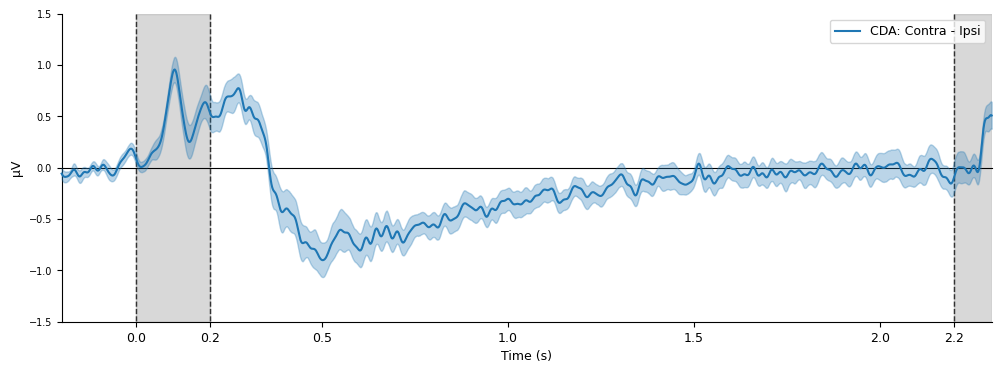

In [8]:

# Plot main CDA wave (grand-average across all conditions):
fig, ax = plt.subplots(1,1,figsize=(12,4))
plot_main_cda(ax, evokeds)
plt.show()

This looks pretty much as we would expect. We follow up with a "temporal
localizer" (Luck & Gaspelin, 2017) to find out for which time-window the CDA in
our data was signifiacantly different from 0. 

stat_fun(H1): min=-5.466396 max=5.243015
Running initial clustering
Found 5 clusters


/tmp/ipykernel_89248/109556893.py:208: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  cluster_stats = permutation_cluster_1samp_test(


Permuting 9999 times...


/u/fklotzsche/conda-envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/u/fklotzsche/conda-envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
combining channels using "mean"


/tmp/ipykernel_89248/109556893.py:264: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout(pad=0.0)


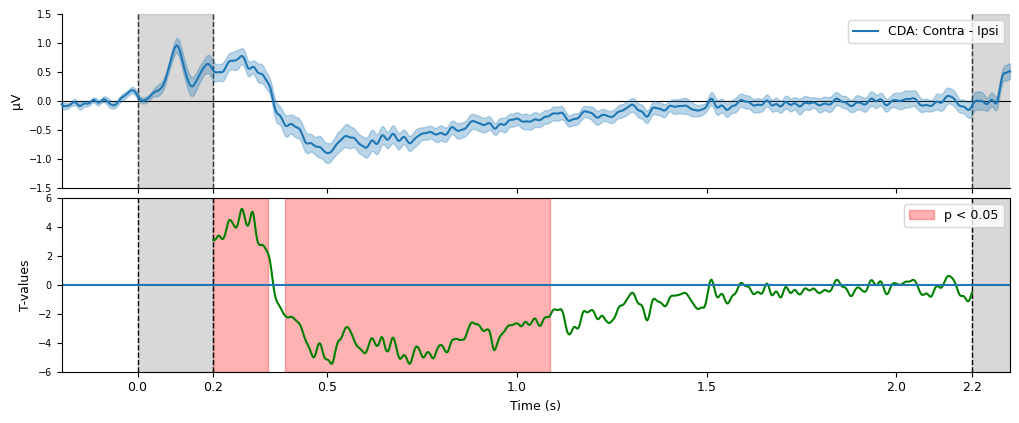

In [9]:
## Run cb-perm test to find intervall of interest:

# get data - cropped to retention interval:
times_full = evokeds['all'][0].times
c_list = [evo.copy().crop(config.times_dict['stim_dur'],
                          config.times_dict['stim_dur'] + config.times_dict['retention_dur'])
          for evo in evokeds['all']]
data = np.array([np.mean(c.data, axis=0) for c in c_list])
times_cbp = c_list[0].times
p_initial = 0.05
p_thresh = 0.05
n_perm = 10000
# run cbp test:
T_obs, clusters, cluster_p_values = run_cbp_test(data, p_initial=p_initial, p_thresh=p_thresh, n_perm=n_perm)

# Plot the result:
fig, axes = plt.subplots(2,1,figsize=(10,4), sharex=True, constrained_layout=True)
plot_main_cda(axes[0], evokeds)
axes[0].xaxis.label.set_visible(False)
plot_cbp_result_cda(axes[1], T_obs, clusters, cluster_p_values, p_thresh, times_cbp, times_full)

# Save it: 
fpath = op.join(config.paths['plots'], 'CDA', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'ERP_lateralized_sign_clusters_cbp.png')
fig.savefig(fname, bbox_inches="tight")


We see two significant clusters: 
- 1 very early in the trial --> this is the PNP
- 1 a bit later --> this is the CDA

In [10]:
# get CDA times:
sign_cluster_idxs = np.where(cluster_p_values < p_thresh)[0]
# pick second sign. cluster
cda_times = times_cbp[clusters[sign_cluster_idxs[1]]]
cda_info_dict = {'cda_sign_cluster_t_start': cda_times[0] * 1000,
                 'cda_sign_cluster_t_end': cda_times[-1] * 1000,
                 'cda_sign_cluster_pval': cluster_p_values[sign_cluster_idxs[1]]}

# Extract vars:
helpers.extract_var("cda_cbp_global_thresh_init", p_initial)
helpers.extract_var("cda_cbp_global_nperms", n_perm, exp_format=".0f")
helpers.extract_var("cda_cbp_2ndlvl_pval", p_thresh, is_pval=True)
for key in cda_info_dict:
    is_pval = "pval" in key
    if is_pval:
        exp_format = '.3f'
    else:
        exp_format = '.0f'
    helpers.extract_var(key, cda_info_dict[key], exp_format=exp_format, is_pval=is_pval)

# get PNP times:
# pick first  sign. cluster
pnp_times = times_cbp[clusters[sign_cluster_idxs[0]]]
pnp_info_dict = {'pnp_sign_cluster_t_start': pnp_times[0] * 1000,
                 'pnp_sign_cluster_t_end': pnp_times[-1] * 1000,
                 'pnp_sign_cluster_pval': cluster_p_values[sign_cluster_idxs[0]]}

# Extract vars:
for key in pnp_info_dict:
    is_pval = "pval" in key
    if is_pval:
        exp_format = '.3f'
    else:
        exp_format = '.0f'
    helpers.extract_var(key, pnp_info_dict[key], exp_format=exp_format, is_pval=is_pval)
    

### Save the mean amplitude data to CSV
To run statistics in R, we export mean amplitudes to CSV.
We do this twice:
1. for a fixed time window that we take from the literature (CDA: [Hakim et al., 2019](https://doi.org/10.1177/0956797619830384); PNP: [Papaioannou & Luck, 2020](https://doi.org/10.1111/psyp.13532)).
2. for a time window that we get in a data-driven fasion by running an agnostic cluster-based permutation test, identifying a time window where the difference wave is significantly different from 0 (across all conditions).

In [11]:
# CDA
## fixed time window:
dff = allsubjects_mean_amp_to_df(
    sub_list, "stimon", config.chans_CDA_dict["Left"], 0.45, 1.45, "CDA"
)
fpath = op.join(config.paths["04_evokeds-CDA"], "summaries", "fixed_times")
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "allsubjects-mean_amp_CDA.csv")
dff.to_csv(fname, float_format="%.15f")

## data driven window
dff = allsubjects_mean_amp_to_df(
    sub_list,
    "stimon",
    config.chans_CDA_dict["Left"],
    cda_times[0],
    cda_times[-1],
    "CDA",
)
dff.groupby("c_StimN").mean()
fpath = op.join(config.paths["04_evokeds-CDA"], "summaries", "cluster_times")
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "allsubjects-mean_amp_CDA.csv")
dff.to_csv(fname, float_format="%.15f")

# PNP
## fixed time window:
dff = allsubjects_mean_amp_to_df(
    sub_list, "stimon", config.chans_CDA_dict["Left"], 0.300, 0.444, "PNP"
)
fpath = op.join(config.paths["04_evokeds-PNP"], "summaries", "fixed_times")
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "allsubjects-mean_amp_PNP.csv")
dff.to_csv(fname, float_format="%.15f")

## data driven window
dff = allsubjects_mean_amp_to_df(
    sub_list,
    "stimon",
    config.chans_CDA_dict["Left"],
    pnp_times[0],
    pnp_times[-1],
    "PNP",
)
fpath = op.join(config.paths["04_evokeds-PNP"], "summaries", "cluster_times")
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "allsubjects-mean_amp_PNP.csv")
dff.to_csv(fname, float_format="%.15f")


Reading VME_S01...
Reading VME_S02...
Reading VME_S03...
Reading VME_S04...
Reading VME_S05...
Reading VME_S06...
Reading VME_S07...
Reading VME_S08...
Reading VME_S09...
Reading VME_S10...
Reading VME_S15...
Reading VME_S16...
Reading VME_S17...
Reading VME_S18...
Reading VME_S20...
Reading VME_S21...
Reading VME_S23...
Reading VME_S24...
Reading VME_S25...
Reading VME_S26...
Reading VME_S27...
Reading VME_S01...
Reading VME_S02...
Reading VME_S03...
Reading VME_S04...
Reading VME_S05...
Reading VME_S06...
Reading VME_S07...
Reading VME_S08...
Reading VME_S09...
Reading VME_S10...
Reading VME_S15...
Reading VME_S16...
Reading VME_S17...
Reading VME_S18...
Reading VME_S20...
Reading VME_S21...
Reading VME_S23...
Reading VME_S24...
Reading VME_S25...
Reading VME_S26...
Reading VME_S27...
Reading VME_S01...
Reading VME_S02...
Reading VME_S03...
Reading VME_S04...
Reading VME_S05...
Reading VME_S06...
Reading VME_S07...
Reading VME_S08...
Reading VME_S09...
Reading VME_S10...
Reading VME_

In the next steps, we plot the CDA as a function of the memory load and of the 
stimulus eccentricity:

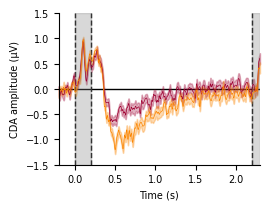

In [12]:
zoomfac = 1  # can be used to produce bigger plots (use 1 for publication)

cm = 1 / 2.54  # convert inch to cm
fig, ax = plt.subplots(1, 1, figsize=(6.6 * cm * zoomfac, 5 * cm * zoomfac))
picks = config.chans_CDA_dict["Left"]  # ['P5']  # ['PO3']  #
conds = ["LoadLow", "LoadHigh"]

# Our plotter function applies the Cousineau correction of the CI, but we need to tell it the number of factor levels:
def ci_func(vec):
    # we want to plot the SEM, so we calculate the according alpha level:
    alpha = 1 - ((scipy.stats.norm.cdf(1) - 0.5) * 2)
    return get_cmci(vec, n_factorlevels=2, alpha=alpha)


ha = plot_main_effect(evokeds, conds, picks, ax, ci_func=ci_func, show_legend=False)

plt.show()

# Save it:
fpath = op.join(config.paths["plots"], "CDA", epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "mainEff_load.pdf")
fig.savefig(fname)  # , bbox_inches="tight")


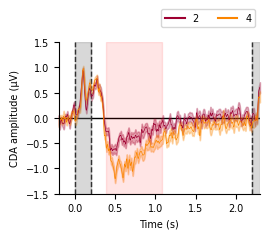

In [13]:
# And here overlaid with the region of the sign. cluster identified earlier by
# the "temporal localizer" method:
fig, ax = plt.subplots(1,1,figsize=(6.6*cm,5*cm))
plot_main_effect(evokeds, conds, picks, ax, sign_cluster=(cda_times[0], cda_times[-1]), ci_func=ci_func, show_legend=True)

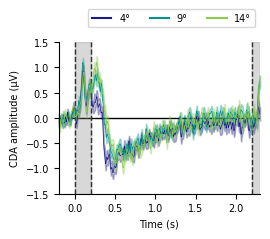

In [14]:
# plot main effect ecc: 
zoomfac = 1
fig, ax = plt.subplots(1,1,figsize=(6.6*cm*zoomfac,5*cm*zoomfac))

def ci_func(vec):
    # we want to plot the SEM, so we calculate the according alpha level:
    alpha = 1 - ((scipy.stats.norm.cdf(1) - 0.5) * 2)
    return get_cmci(vec, n_factorlevels=3, alpha=alpha)
conds = ['EccS', 'EccM', 'EccL']
plot_main_effect(evokeds, conds, picks, ax, ci_func=ci_func, show_legend=True)


In [15]:

# Save it: 
fpath = op.join(config.paths['plots'], 'CDA', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'mainEff_ecc.pdf')
fig.savefig(fname, bbox_inches="tight")

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


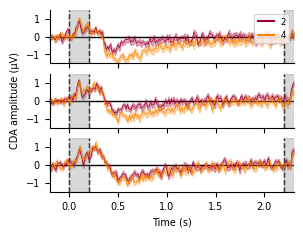

In [16]:
fig, axs = plt.subplots(3,1, figsize=(8*cm,6*cm))

# 
def ci_func(vec):
    # we want to plot the SEM, so we calculate the according alpha level:
    alpha = 1 - ((scipy.stats.norm.cdf(1) - 0.5) * 2)
    return get_cmci(vec, n_factorlevels=2, alpha=alpha)
    # note that I am only correcting the SEMs for the 2 MemLoad levels, not for the eccentricity. Too much effort for a supplementary plot and anyways questionable to compare SEMs across subplots. Note that this only affects the visualization not the stat. results.
plot_interaction_eff(evokeds, picks, axs, ci_func, show_ecc=False)
plt.show()
# Save it:
fpath = op.join(config.paths['plots'], 'CDA', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'interaction_loadxecc.pdf')
fig.savefig(fname, bbox_inches="tight")

# Supplementary analyses

### 1. Does the chosen ROI (based on Hakim et al., 2015) reflect a strong CDA also in our data?

In [17]:
def plot_mean_cda_roi(mean_cda, ch_names_lat, ax, pal=None, scale=1.0, ytick_rot=65, ha='right'):
    sorted_w_idx = sorted([(v, i)
                          for i, v in enumerate(mean_cda.mean(axis=0))])
    idx_sorted = [i[1] for i in sorted_w_idx]

    idx_roi = [ch_names_lat.index(c) for c in config.chans_CDA_dict['Left']]

    cda_df = pd.DataFrame()

    cda_roi = np.mean(mean_cda[:, idx_roi], axis=-1)
    cda_df['our ROI'] = cda_roi
    cda_df['   '] = [-999] * len(mean_cda)

    our_roi_str = ['PO3/4', 'PO7/8', 'O1/2', 'P3/4', 'P5/6']

    n_rois = 20
    for i in range(n_rois):
        idx_sel = idx_sorted[:i+1]
        # cda_sel = np.mean(mean_cda[:,idx_sel], axis=-1)  # <-- plot mean for cumulative ROI
        cda_sel = mean_cda[:, idx_sel[-1]]  # <-- plot channels separately
        name = ch_names_lat[idx_sorted[i]] + '/' + \
            str(int(ch_names_lat[idx_sorted[i]][-1])+1)  # (i>0)*'+ ' +
        if name in our_roi_str:
            name += '*'
        cda_df[name] = cda_sel

    if pal is None:
        cols = list(sns.color_palette('viridis_r', n_rois+1))
        cols.insert(0, 'turquoise')  # cols[4])
        pal = {n: c for n, c in zip(cda_df.columns, cols)}
    else:
        pal_c = pal.copy()
        for cn in cda_df:
            comps = [p for p in pal_c if ((cn in p) or (p in cn))]
            if any(comps):
                pal[cn] = pal[comps[0]]
            else:
                pal[cn] = 'grey'

    # cda_df.boxplot(vert=False)
    val_name = f'mean CDA [+-1SEM] ({chr(956)}V)'
    ll = cda_df.melt(var_name='ROI', value_name=val_name)
    xx = list(range(10)) + [13]
    out = sns.pointplot(data=ll,
                        x='ROI',
                        y=val_name,
                        palette=pal,
                        errorbar='se',  # ('ci', 2),
                        dodge=True,
                        scale=scale,
                        errwidth=scale*3.5,
                        ax=ax)
    xticks = ax.get_xticks()
    xlabs = ax.get_xticklabels()
    ax.axhline(np.mean(cda_roi), color=pal['our ROI'], linestyle=':')
    ax.set_xticks(ticks=xticks, labels=xlabs, rotation=ytick_rot, ha=ha)
    ax.set_ylim(-0.8, 0.15)
    # ax.set_xlim(-0.6,0.2)

    return pal


In [18]:
# Load the evoked data:

from multiprocessing import Pool
from functools import partial

plt_dict_allchans = plt_dict.copy()
plt_dict_allchans['picks'] = []

# the following is the way faster but more cryptic version of:
# evokeds_allchans = get_evokeds_dict(sub_list, epo_part, plt_dict_allchans,
#                                     data_type="difference")

with Pool(len(sub_list)) as p:
    out = p.map(
        partial(
            get_evokeds_dict,
            epo_part=epo_part,
            plt_dict=plt_dict_allchans,
            data_type="difference",
        ),
        [[s] for s in sub_list]
    )
evokeds_allchans = {k : [d[k][0] for d in out] for d in out for k in d}

conds = ['all', 'EccS', 'EccM', 'EccL']
mean_cdas = dict()
for cond in conds: 
    cdas = np.asarray([c.copy().crop(0.4, 1.45).data for c in evokeds_allchans[cond]])
    mean_cdas[cond] = np.mean(cdas, axis=(-1)) * 1e6

ch_names_lat = evokeds_allchans['all'][0].ch_names

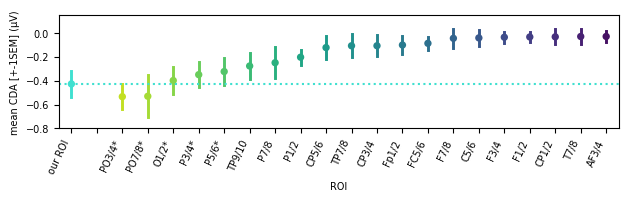

In [19]:
fig1, ax1 = plt.subplots(1,1, figsize=(16 * cm, 5 * cm))
pal = plot_mean_cda_roi(mean_cdas['all'], ch_names_lat=ch_names_lat, ax=ax1, scale=0.6)
fig1.tight_layout()

# Save it:
fpath = op.join(config.paths['plots'], 'CDA', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'CDA_ROIvsChans_allEcc.svg.pdf')
fig1.savefig(fname, bbox_inches="tight")


We see that our ROI (as taken from Hakim et al, 2019) is a pretty good representative of the channels with the strongest CDA.
Note that here we took the CDA time window [0.400 - 1.450] as suggested by Hakim et al. (2019) to not be biased towards our data.  

Especially, we will see that this pattern is fairly stable across all eccentricity conditions. Therefore, it is unlikely that there is an effect of eccentricity on the topography of the CDA.

<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_89248/1879160115.py:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if cond is not 'EccS':


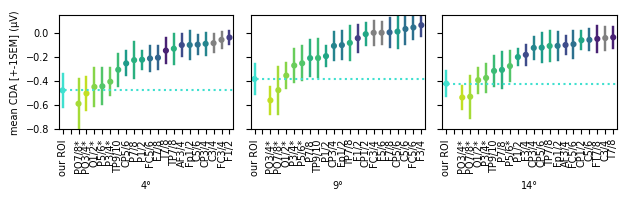

In [20]:

fig2, axes = plt.subplots(1,3, sharey=True, figsize=(16 * cm, 5 * cm))

conds_ecc = ['EccS', 'EccM', 'EccL']
for cond, ax in zip(conds_ecc, axes):
    plot_mean_cda_roi(mean_cda=mean_cdas[cond], ch_names_lat=ch_names_lat, ax=ax, pal=pal, scale=0.5, ytick_rot=90, ha='center') 
    ax.set_xlabel(config.labels[cond])
    if cond is not 'EccS':
        ax.set_ylabel('')
fig2.tight_layout()
# Save it:
fpath = op.join(config.paths['plots'], 'CDA', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'CDA_ROIvsChans_perEcc.svg.pdf')
fig2.savefig(fname, bbox_inches="tight")

y-axis: mean CDA for a given ROI in the time-window [0.4; 1.45]s  
x-axis: left most is our ROI as adapted from Hakim et al. (2019): [PO3/4, PO7/8, O1/2, P3/4, P5/6];  
we compare it with the single channels sorted by (decreasing) CDA size.  
Note that the color-to-channel matching is the same for each plot. Channels marked with * are constituents of our ROI.  
Importantly, this looks very similar across all eccentricity conditions. 


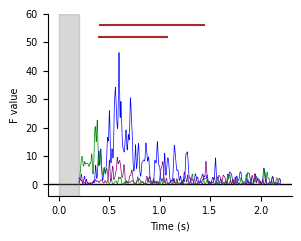

In [22]:
from mne.stats import f_mway_rm, f_threshold_mway_rm

cond_dict = {"Load": ["LoadLow", "LoadHigh"], "Ecc": ["EccS", "EccM", "EccL"]}
df_list = list()
for load in cond_dict["Load"]:
    for ecc in cond_dict["Ecc"]:

        diffs_ = evokeds_allchans[load + ecc]
        df_list.extend([np.mean(d.copy().pick(config.chans_CDA_dict['Contra']).data, axis=0, keepdims=True) for d in diffs_])
    times = diffs_[0].times
    ch_names = diffs_[0].ch_names

# Setup parameters:
decim = 2
factor_levels = [2, 3]
effects = "A*B"
n_levels = np.multiply(*factor_levels)
n_chans = df_list[0].shape[-2]
n_times = df_list[0].shape[-1]
n_subs = int(len(df_list) / n_levels)


# Shape data matrix: subjects x effects x n_channels*n_times
subtfr_array = np.asarray(df_list)
subtfr_mway_data = subtfr_array.reshape(n_levels, n_subs, n_chans * n_times)
subtfr_mway_data = subtfr_mway_data.swapaxes(0, 1)

fvals, pvals = f_mway_rm(subtfr_mway_data, factor_levels, effects=effects)

# crop to retention interrval:
t_start = np.where(times == 0.2)[0]
t_end = np.where(times == 2.2)[0]
fvals = fvals[:, t_start[0]:t_end[0]]
times_ret = times[t_start[0]:t_end[0]]

fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
ax.plot(times_ret, fvals.T, linewidth=0.5)
colors = ('blue', 'green', 'purple')
labels = ('main effect: memory load', 'main effect: eccentricity', 
          'interaction effect: memory load x eccentricity')
for c, l in zip(colors, ax.lines):
    l.set_color(c)
    l.set_label(l)
ax.set_ylim(-4, 60)
ax.set_ylabel("F value")
ax.set_xlabel("Time (s)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(0, color='k', linewidth=1., zorder=-2)
ax.axvspan(0, 0.2, color='grey', alpha=0.3)

# original time window:
ax.hlines(
    52,
    xmin=cda_times[0],
    xmax=cda_times[-1],
    color='brown',
    label='original CDA time-window',
)

# alternative time window:
ax.hlines(
    56,
    xmin=0.4,
    xmax=1.45,
    color='brown',
    label='original CDA time-window',
)

# Save it:
fpath = op.join(config.paths["plots"], "CDA", epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "ANOVA_effects.pdf")
fig.savefig(fname, bbox_inches="tight")